# Extracting, Representing, Validating and Visualizing Data from an OMOP CDM Database with EHRData, lamin and Vitessce

## Background
This jupyter notebook walks through the workflow which we want to refine, expand, and expand during the '24 hackathon!

In a nutshell
1. Extract data from a database of the [OMOP Common Data Model](https://ohdsi.github.io/CommonDataModel/index.html)
2. Represent this data in an [ehrdata](https://ehrdata.readthedocs.io/en/latest/#) object
3. Validate this ehrdata object using [lamin](https://lamin.ai/) functionality (optional but recommended)
4. Visualize this data with [Vitessce](https://vitessce.io/), either in a notebook or on cloud storage via lamin hub.

### OMOP
[OMOP](https://ohdsi.github.io/CommonDataModel/index.html) is a data model by [OHDSI](https://www.ohdsi.org/).

#### The Example Dataset used: MIMIC IV OMOP Demo Dataset
Dataset available on [Physionet](https://physionet.org/content/mimic-iv-demo-omop/0.9/).

Dataset:<br>
Kallfelz, M., Tsvetkova, A., Pollard, T., Kwong, M., Lipori, G., Huser, V., Osborn, J., Hao, S., & Williams, A. (2021). MIMIC-IV demo data in the OMOP Common Data Model (version 0.9). PhysioNet. https://doi.org/10.13026/p1f5-7x35.

Physionet:<br>
Goldberger, A., Amaral, L., Glass, L., Hausdorff, J., Ivanov, P. C., Mark, R., ... & Stanley, H. E. (2000). PhysioBank, PhysioToolkit, and PhysioNet: Components of a new research resource for complex physiologic signals. Circulation [Online]. 101 (23), pp. e215–e220.

### Extract
This notebook guides you through the extraction from data following the OMOP CDM.

### Represent
See [ehrdata](https://ehrdata.readthedocs.io/en/latest/#) for more information on ehrdata.

### Validate
See [lamin](https://lamin.ai/) for more information on lamin.

### Visualize
See [Vitessce](https://vitessce.io/) for more information on Vitessce

## The extraction workflow

Here, we use [duckdb](https://duckdb.org/)'s Python API to load csv tables as they are available from the link above. (which is absolutely useless for immediate purposes but why not)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import anndata as ad
import duckdb
import ehrapy as ep
import ehrdata as ed
import ehrdata
import numpy as np

In [4]:
from widgets import create_single_option_widget, create_multiple_options_widget

In [12]:
options = ["person", "observation_period", "visit_occurrence", "condition_occurrence"]

ui_obs, selected_obs = create_single_option_widget(
    title_text="Please select which table should be used for .obs indexing in ehrdata:",
    options=options,
)

In [13]:
options = ["measurement", "observation", "drug_occurrence"]
ui_var, selected_vars = create_multiple_options_widget(title_text="Options to use as the variables", options=options)

In [14]:
options = [
    "pca",
    "umap",
]
ui_emb, selected_emb = create_single_option_widget(
    title_text="Please select which embedding do you want to use:",
    options=options,
)

### Set up a local database connection

In [15]:
con = duckdb.connect()

Load the data into your database

In [16]:
ehrdata.dt.mimic_iv_omop(backend_handle=con)

Path to data exists, load tables from there: ehrapy_data/mimic-iv-demo-data-in-the-omop-common-data-model-0.9
missing tables:  [['concept'], ['vocabulary'], ['domain'], ['concept_class'], ['concept_relationship'], ['relationship'], ['concept_synonym'], ['concept_ancestor'], ['source_to_concept_map'], ['drug_strength']]


See what tables there are

In [17]:
tables = con.execute("SHOW TABLES;").df()
tables

,name
0,care_site
1,cdm_source
2,cohort
3,cohort_definition
4,condition_era
5,condition_occurrence
6,cost
7,death
8,device_exposure
9,dose_era


In [18]:
display(ui_obs)

In [ ]:
# if obs_base.value == 'person':
#     obs = ehrdata.io.omop.extract_person(con)
# elif obs_base.value == 'observation_period':
#     obs = ehrdata.io.omop.extract_observation_period(con)
# elif obs_base.value == 'visit_occurrence':
#     obs = ehrdata.io.omop.extract_visit_occurrence(con)
# elif obs_base.value == 'condition_occurrence':
#     obs = ehrdata.io.omop.extract_condition_occurrence(con)

# obs.head()

if selected_obs.value == "person":
    edata = ed.io.omop.setup_obs(con, "person_observation_period")

edata

,person_id,gender_concept_id,year_of_birth,month_of_birth,day_of_birth,birth_datetime,race_concept_id,ethnicity_concept_id,location_id,provider_id,care_site_id,person_source_value,gender_source_value,gender_source_concept_id,race_source_value,race_source_concept_id,ethnicity_source_value,ethnicity_source_concept_id
0,3589912774911670296,8507,2095,None,None,None,0,38003563,None,None,None,10009628,M,0,None,0,HISPANIC/LATINO,2000001408
1,-3210373572193940939,8507,2079,None,None,None,0,38003563,None,None,None,10011398,M,0,None,0,HISPANIC/LATINO,2000001408
2,-775517641933593374,8507,2149,None,None,None,8516,0,None,None,None,10004235,M,0,BLACK/AFRICAN AMERICAN,2000001406,None,0
3,-2575767131279873665,8507,2050,None,None,None,8516,0,None,None,None,10024043,M,0,BLACK/AFRICAN AMERICAN,2000001406,None,0
4,-8970844422700220177,8507,2114,None,None,None,8527,0,None,None,None,10038933,M,0,WHITE,2000001404,None,0


##### Interlude - Irregularly sampled time series data
Electronic health records can be regarded as (that is, form a model of a person via) irregular sampling irregularly sampled time series.

Following notation and explanation from [Horn et al.](https://proceedings.mlr.press/v119/horn20a.html), a time series of a patient can be described as a set of tuples (t, z, m), where t denotes the time, z the observed value, and m a modality description of the measurement.

The time series can have different lengths, and a "typical" number of observed values might not exist.

Generally, an irregularly-sampled time series can be converted into a missing data problem by discretizing the time axis into non-overlapping intervals, and declaring intervals in which no data was sampled as missing (Bahadori & Lipton, 2019). [Horn et al.](https://proceedings.mlr.press/v119/horn20a.html).

EHRData's extract_XXXX extracts irregularly sampled time series from OMOP tables XXX.

TODO add illustration

EHRData's time_interval_table transforms this into the missing data problem with discretized time axis.

TODO add illustration


In [95]:
display(ui_var)

In [89]:
edata = ed.io.omop.setup_variables(
    backend_handle=con,
    edata=edata,
    tables=list(selected_vars.value),
    start_time="observation_period_start_date",
    interval_length_number=28,
    interval_length_unit="day",
    num_intervals="max_observation_duration",
    concept_ids="all",
    aggregation_strategy="last",
)

In [10]:
edata.r[:3, :3, :3]

array([[[ nan,  nan,  nan],
        [ -1.,  nan,  nan],
        [ nan,  nan,  nan]],

       [[ nan,  nan,  nan],
        [  1.,  nan,  nan],
        [ nan,  nan,  nan]],

       [[413.,  nan,  nan],
        [-15.,  nan,  nan],
        [ nan,  nan,  nan]]])

In [11]:
edata.r.shape

In [12]:
edata.X = np.nanmean(edata.r, 2)

<Axes: >

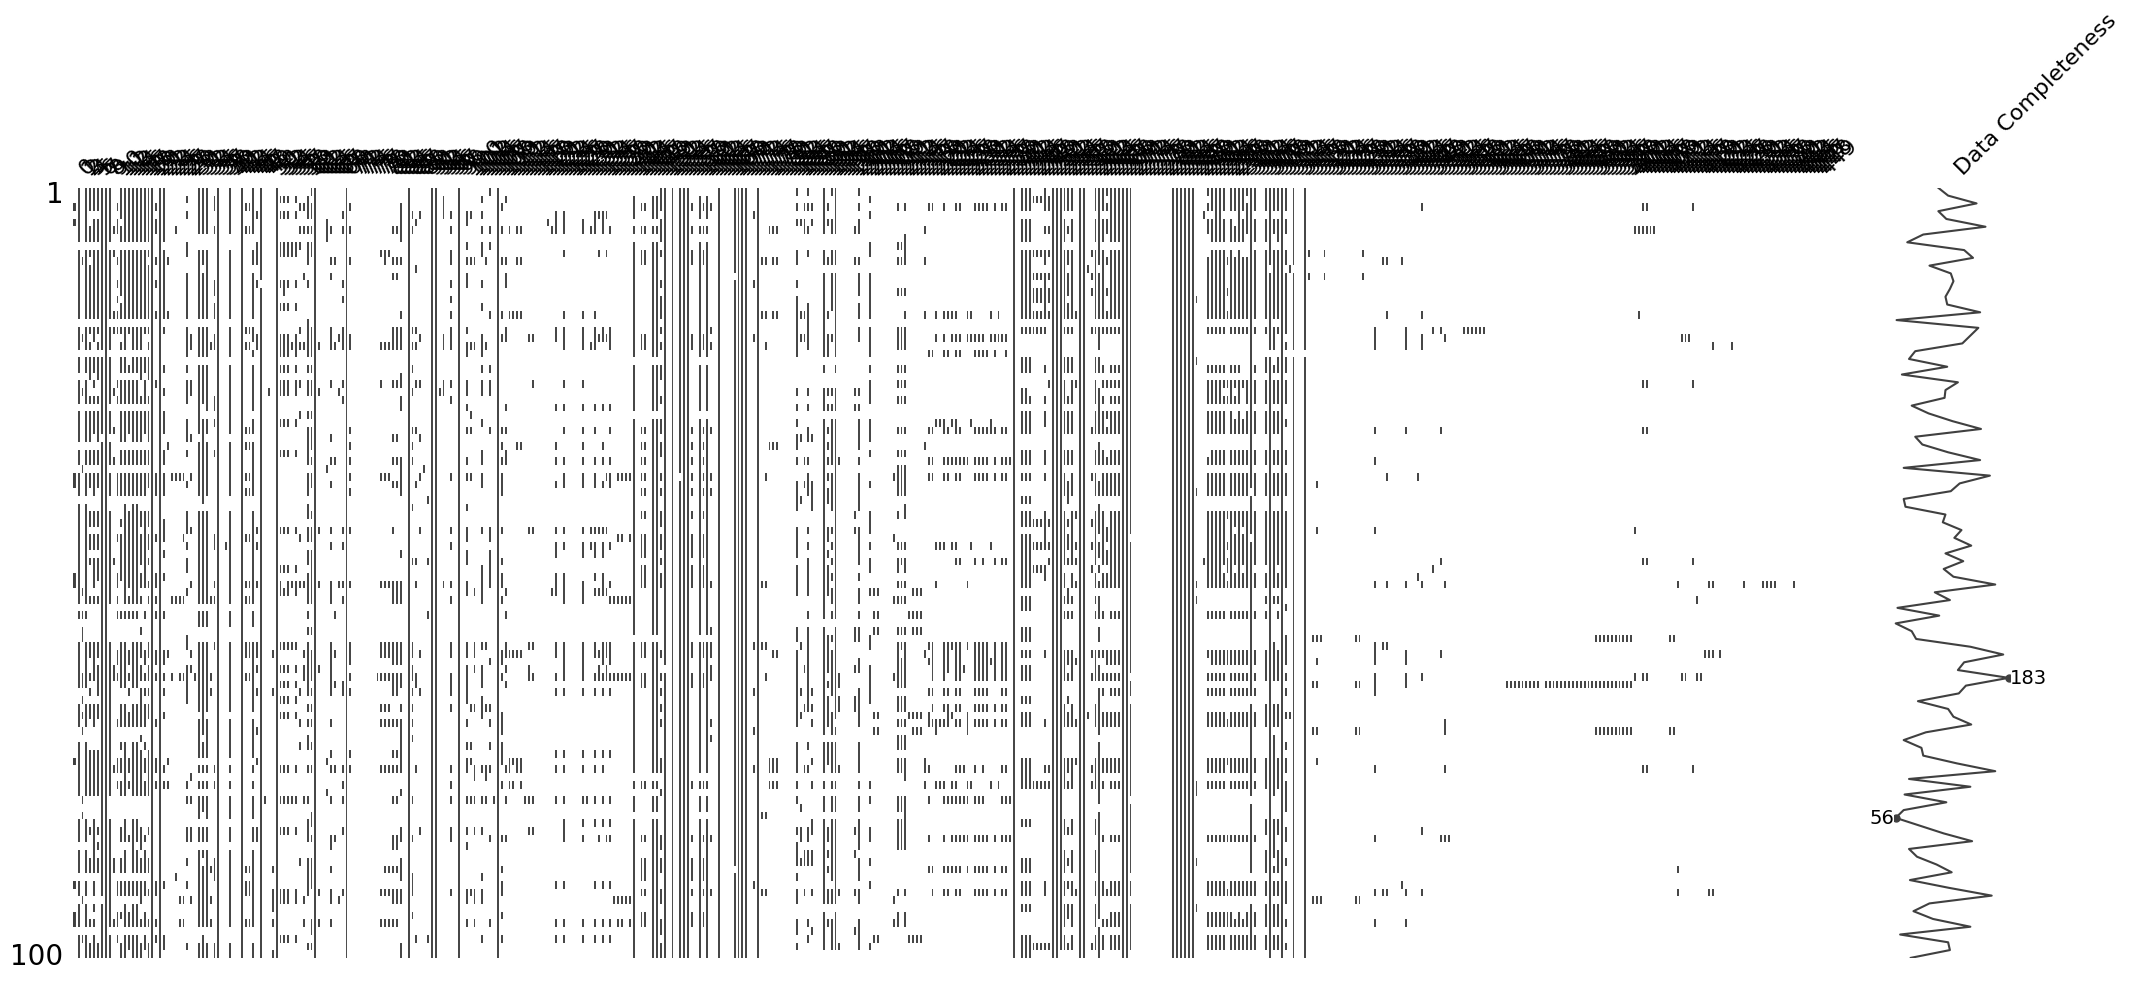

In [13]:
ep.pl.missing_values_matrix(edata)

In [14]:
ep.pp.explicit_impute(edata, replacement=0)

! Feature '51' had more than 92.00% missing values!
! Feature '197' had more than 92.00% missing values!
! Feature '47' had more than 82.00% missing values!
! Feature '42' had more than 100.00% missing values!
! Feature '289' had more than 91.00% missing values!
! Feature '353' had more than 94.00% missing values!
! Feature '370' had more than 99.00% missing values!
! Feature '215' had more than 97.00% missing values!
! Feature '404' had more than 93.00% missing values!
! Feature '336' had more than 100.00% missing values!
! Feature '31' had more than 99.00% missing values!
! Feature '359' had more than 99.00% missing values!
! Feature '28' had more than 94.00% missing values!
! Feature '127' had more than 100.00% missing values!
! Feature '227' had more than 76.00% missing values!
! Feature '346' had more than 98.00% missing values!
! Feature '380' had more than 99.00% missing values!
! Feature '50' had more than 99.00% missing values!
! Feature '80' had more than 86.00% missing value

Output()

In [15]:
edata.X

array([[  0.,  -1.,   0., ...,   0.,   0.,   0.],
       [  0.,   1.,   0., ...,   0.,   0.,   0.],
       [413., -15.,   0., ...,   0.,   0.,   0.],
       ...,
       [  0.,  -3.,  27., ...,   0.,   0.,   0.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  0.,  -2.,   0., ...,   0.,   0.,   0.]])

In [14]:
# for now few things to run smoothly...

### Lamin Validation



In [ ]:
!lamin connect theislab/ehr

→ connected lamindb: theislab/ehr


In [ ]:
!lamin login # add username and key

✓ logged in with handle mdldan (uid: pwy0zmMg)


In [ ]:
!lamin info

Current user: mdldan
- handle: mdldan
- email: daniele.lucarelli@tum.de
- uid: pwy0zmMg
Auto-connect in Python: True
Private Django API: False
Current instance: theislab/ehr
- owner: theislab
- name: ehr
- storage root: s3://lamin-us-east-1/CLREazecIX5T
- storage region: us-east-1
- db: postgresql://f827a4a00b764d999df500e21c8e1dc7_root.efdukxvxjzsqrsvcfsjx:***@***:6543/f827a4a00b764d999df500e21c8e1dc7
- schema: {'omop', 'bionty'}
- git_repo: None


In [49]:
import omop as op

In [41]:
import pandas as pd

#### Prepare inputs

In [31]:
edata.var.rename(columns={0: "concept_id"}, inplace=True)

In [25]:
# Concepts vocabulary from OMOP. Intersection with ehdata.var
omop_concepts = pd.read_csv("./metadata/omop_validation_slice.csv")

In [39]:
# change the type to match `omop.Concept` typing
omop_concepts = omop_concepts.astype(
    {
        "standard_concept": "str",
        "invalid_reason": "str",
    }
)

In [40]:
DEFAULTS_VALUES_VAR = {
    "concept_id": int,
    "concept_name": str,
    "domain_id": str,
    "vocabulary_id": str,
    "concept_class": str,
    "standard_concept": (str, type(None)),
    "concept_code": str,
    "valid_start_date": str,
    "valid_end_date": str,
    "invalid_reason": (str, type(None)),
}

for column, expected_type in DEFAULTS_VALUES_VAR.items():
    # Check if the column exists in the DataFrame
    if column not in omop_concepts.columns:
        raise ValueError(f"Required column '{column}' is missing from the DataFrame.")

    # Adjust type check for string columns (object is the pandas dtype for strings)
    if expected_type is str:
        if omop_concepts[column].dtype != "object":
            raise TypeError(f"Column '{column}' has incorrect data type. Expected string (object in pandas).")
    elif isinstance(expected_type, tuple):  # For optional fields (e.g., str or None)
        if not omop_concepts[column].map(lambda x, expected_type=expected_type: isinstance(x, expected_type)).all():
            raise TypeError(f"Column '{column}' has incorrect data type. Expected one of {expected_type}.")
    else:  # For other mandatory fields
        if not omop_concepts[column].map(lambda x, expected_type=expected_type: isinstance(x, expected_type)).all():
            raise TypeError(f"Column '{column}' has incorrect data type. Expected {expected_type.__name__}.")

#### Push to lamin

In [ ]:
# Skip, concepts already pushed Lamin
concepts = [op.Concept(**row.to_dict()) for _, row in omop_concepts.iterrows()]
for concept in concepts:
    concept.save()

#### EHR curator

In [80]:
curator = ehrdata.tl.EHRCurator(
    edata=edata,
    concepts_var_column="concept_id",
)

• 24 non-validated values are not saved in Feature.name: ['missing_values_abs', 'race_concept_id', 'month_of_birth', 'observation_period_start_date', 'birth_datetime', 'location_id', 'person_source_value', 'provider_id', 'period_type_concept_id', 'missing_values_pct', 'race_source_concept_id', 'gender_source_value', 'year_of_birth', 'ethnicity_source_concept_id', 'ethnicity_concept_id', 'observation_period_id', 'gender_source_concept_id', 'gender_concept_id', 'person_id', 'care_site_id', 'ethnicity_source_value', 'race_source_value', 'day_of_birth', 'observation_period_end_date']!
      → to lookup values, use lookup().columns
      → to save, run add_new_from_columns


In [81]:
edata = curator.validate_adata(op)

In [75]:
edata

EHRData object with n_obs x n_var = 100 x 450, and a timeseries of 1 steps.
             shape of .X: (100, 450) 
             shape of .r: ((0, 0, 0)) 

<Axes: xlabel='valid_concept_id'>

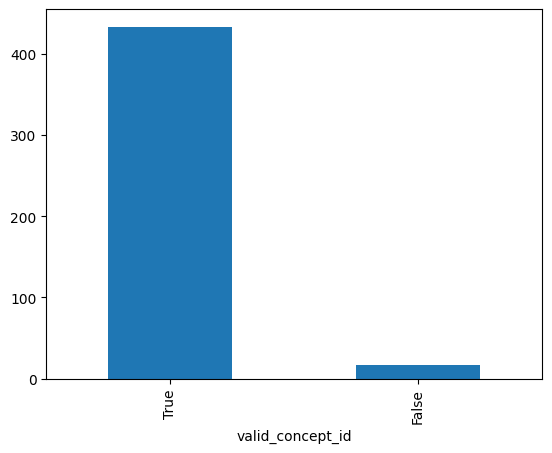

In [76]:
edata.var.valid_concept_id.value_counts().plot(kind="bar")

#### Visualization

In [92]:
display(ui_emb)

In [ ]:
ep.pp.pca(edata)
if selected_emb.value == "umap":
    ep.pp.neighbors(edata)
    ep.tl.umap(edata)

In [ ]:
adata = ad.AnnData(X=edata.X, obs=edata.obs, var=edata.var)

#### Q: why is any of this interesting?
#### A: because now ehrapy and more tools in the future of its ecosystem (like with scanpy) can nicely access this!

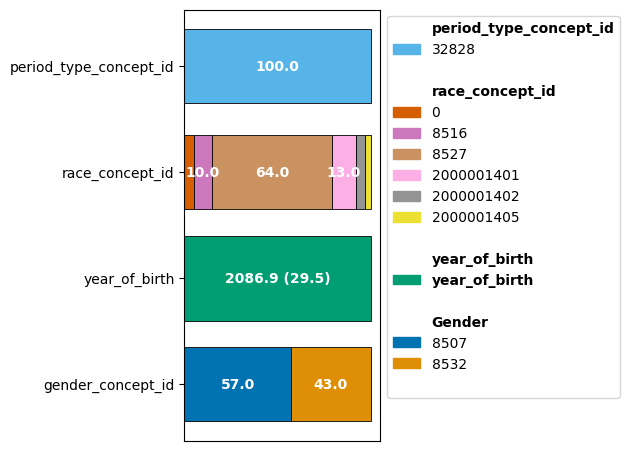

In [18]:
ct = ep.tl.CohortTracker(
    edata,
    columns=[
        "gender_concept_id",
        "year_of_birth",
        "race_concept_id",
        "period_type_concept_id",
    ],
    categorical=["gender_concept_id", "race_concept_id", "period_type_concept_id"],
)

ct(edata)

ct.plot_cohort_barplot(
    legend_labels={
        # 0: "Unknown",
        # 8516: "Black or African American",
        # "year_of_birth": "Birthyear (artificial)",
        # 8507: "Male",
        # 8532: "Female",
    },
    legend_subtitles_names={"gender_concept_id": "Gender"},
)

### Visualization with Vitessce in notebook

1. Import dependencies

In [20]:
from pathlib import Path

from vitessce.data_utils import optimize_adata, VAR_CHUNK_SIZE

2. Save the AnnData object to Zarr

In [29]:
zarr_filepath = Path("data", "processed_ehrdata.zarr")

In [30]:
if not zarr_filepath.is_dir():
    edata = optimize_adata(
        edata,
        obs_cols=["gender_concept_id", "race_concept_id"],
        obsm_keys=["X_pca", "X_umap"],
        optimize_X=True,
    )
    edata.write_zarr(zarr_filepath, chunks=[edata.shape[0], VAR_CHUNK_SIZE])
else:
    print(f"path exists, did not write new file: {zarr_filepath}")

path exists, did not write new file: data/processed_ehrdata.zarr


3. Create a Vitessce view config

In [31]:
import ehrdata.pl.vitessce

vc = ehrdata.pl.vitessce.gen_config(zarr_filepath)

4. Create the Vitessce widget

In [32]:
vw = vc.widget()
vw

VitessceWidget(config={'version': '1.0.15', 'name': 'Dummy EHRData', 'description': '', 'datasets': [{'uid': '…

Should look like this:
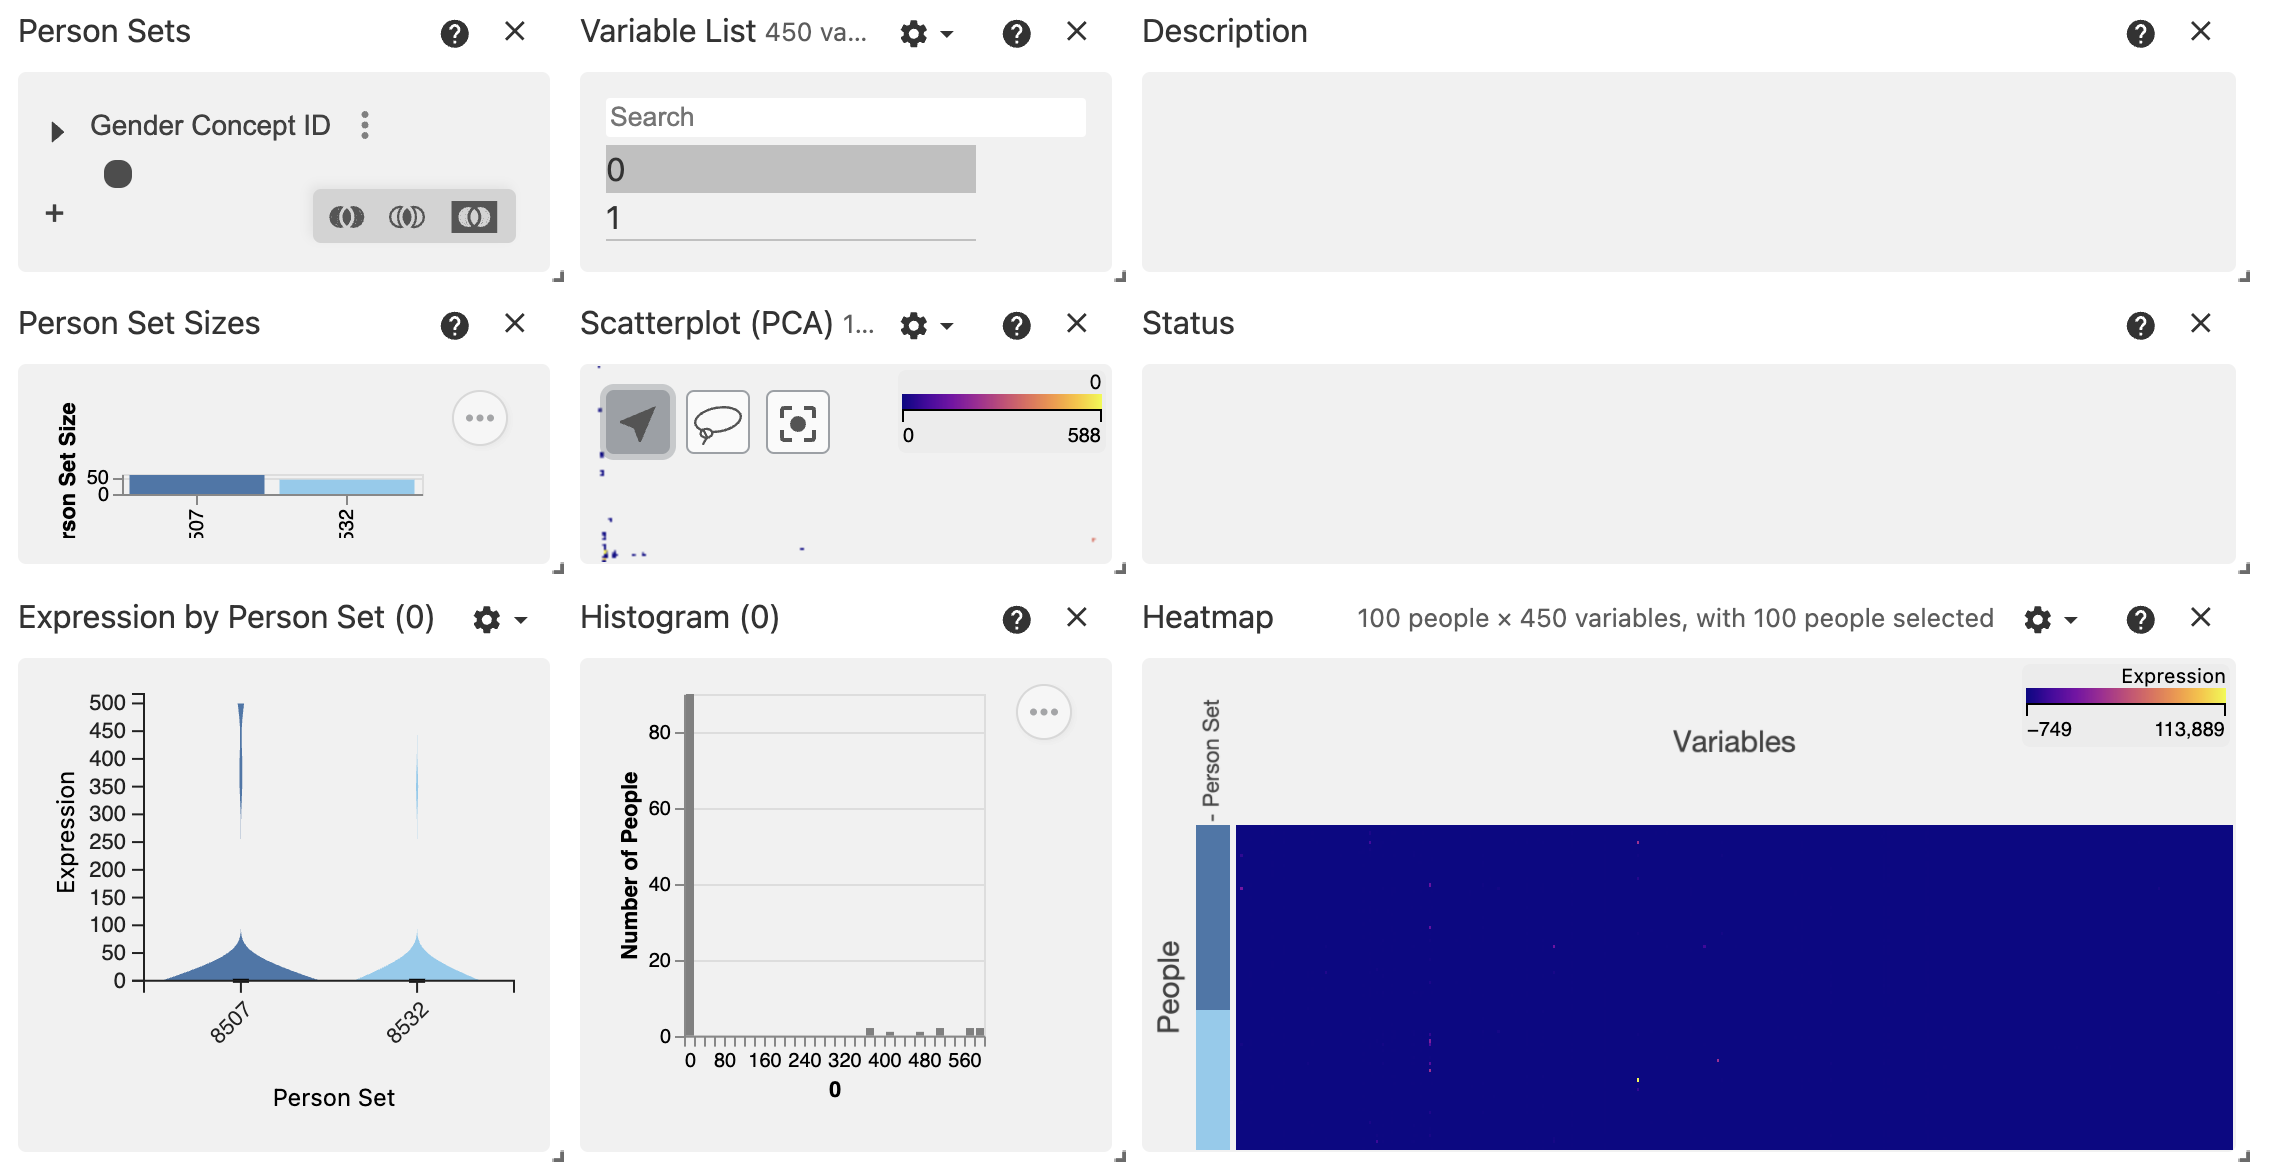

### Visualization with Vitessce on lamin
Uploading dataset on lamin allows even easier sharing and looking at dataset together. Together with the dedicated validation functionality that lamin has and we might extend, this makes lamin + ehrdata a powerful coupling.

This requires to connect to lamindb from terminal
```
lamin login <credentials>
```

In [ ]:
import lamindb as ln

In [ ]:
zarr_artifact = ln.Artifact(
    zarr_filepath,
    description="Dummy EHRDataset",
)
zarr_artifact.save()

In [ ]:
vc = ehrdata.pl.vitessce.gen_config(artifact=zarr_artifact)
vc.widget()

In [27]:
from lamindb.integrations import save_vitessce_config

In [ ]:
vc_artifact = save_vitessce_config(vc, description="Dummy OMOP prepared dataset")

Now our data is stored on the cloud, managed by lamin:
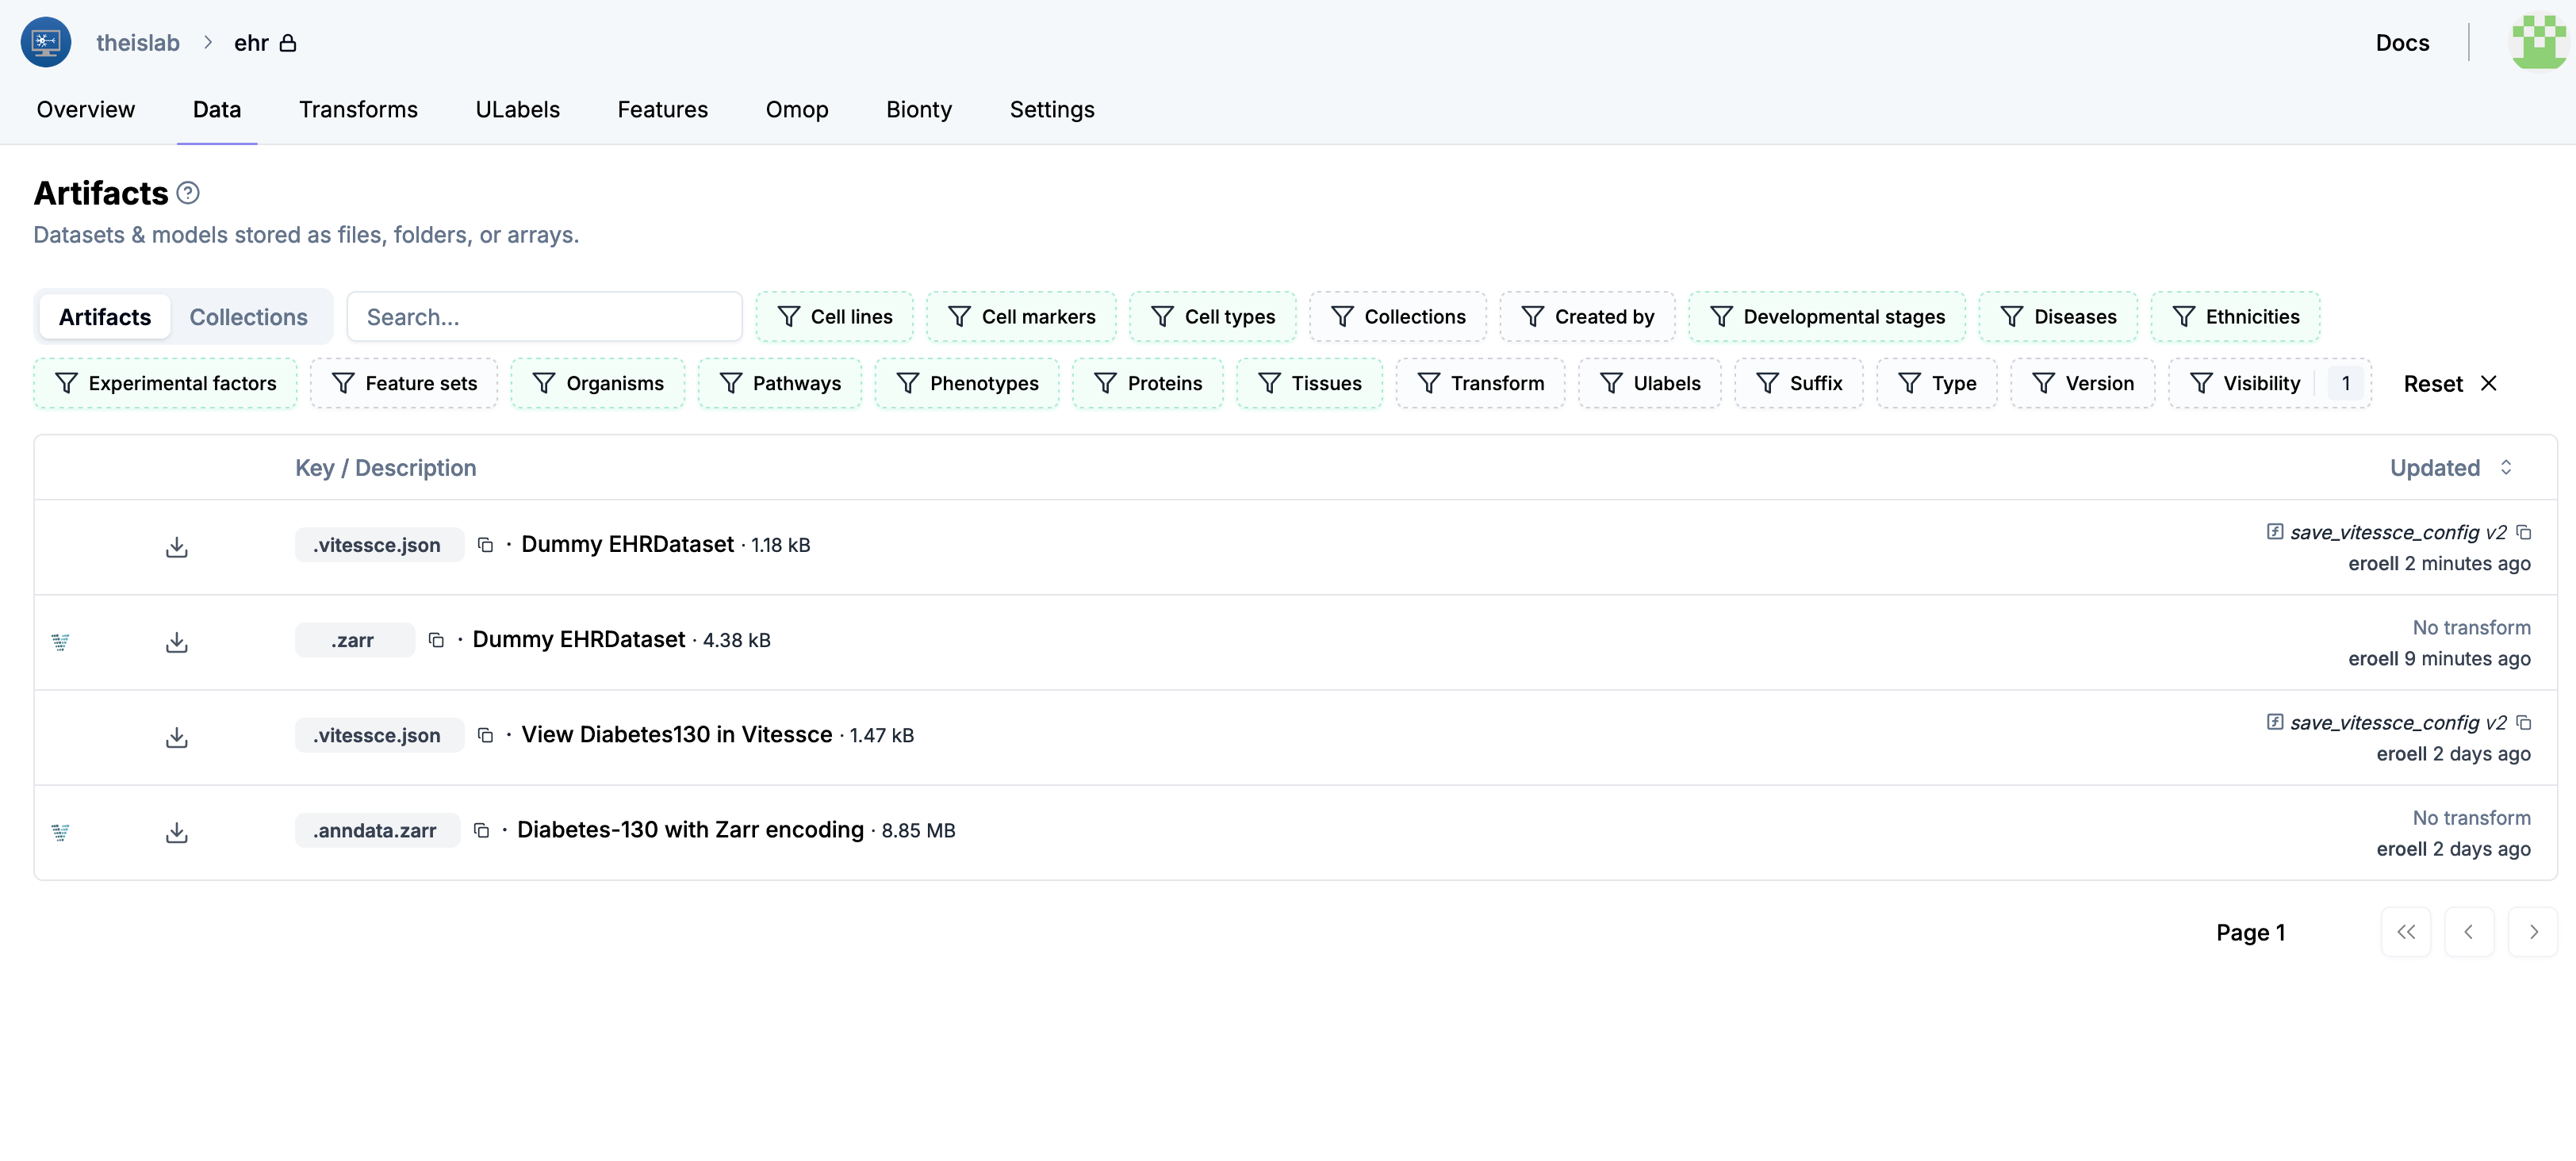

Now we can share the data with others easily, and give them a look at it: all they need is access to our lamin storage & click the vitessce button next to the dataset in their browser!

### Bonus: Lamin utility
Using lamin offers a lot of powerful tracking of our data and how we operated on it.

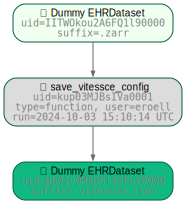

In [82]:
vc_artifact.view_lineage()